<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" style="height:450px;" width=500/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>
<h3 style="text-align: center;"><b>Базовый поток. Осень 2020</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Библиотека sklearn и классификация с помощью KNN</b></h1>

На основе [курса по Машинному Обучению ФИВТ МФТИ](https://github.com/ml-mipt/ml-mipt) и [Открытого курса по Машинному Обучению](https://habr.com/ru/company/ods/blog/322626/).

---

<h2 style="text-align: center;"><b>K Nearest Neighbors (KNN)</b></h2>

Метод ближайших соседей (k Nearest Neighbors, или kNN) — очень популярный метод классификации, также иногда используемый в задачах регрессии. Это один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей; какие преобладают --- таков и ты. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 

<img src='https://hsto.org/web/68d/a45/6f0/68da456f00f8434e87628dbe7e3f54a7.png' width=600>


Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

* Вычислить расстояние до каждого из объектов обучающей выборки
* Отобрать объектов обучающей выборки, расстояние до которых минимально
* Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей

Будем работать с подвыборкой из [данных о типе лесного покрытия из репозитория UCI](http://archive.ics.uci.edu/ml/datasets/Covertype). Доступно 7 различных классов. Каждый объект описывается 54 признаками, 40 из которых являются бинарными. Описание данных доступно по ссылке.

### Обработка данных

In [2]:
import pandas as pd
import numpy as np

In [40]:
header = ["Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    *["Wilderness_Area_" + str(i) for i in range(4)],
    *["Soil_Type_" + str(i) for i in range(40)],
    "Cover_Type"]

Сcылка на датасет (лежит в папке): https://drive.google.com/drive/folders/16TSz1P-oTF8iXSQ1xrt0r_VO35xKmUes?usp=sharing

In [39]:
all_data = pd.read_csv('forest_dataset.csv', names=header)
all_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
1,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
2,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
3,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
4,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1


In [4]:
all_data.shape

(10000, 55)

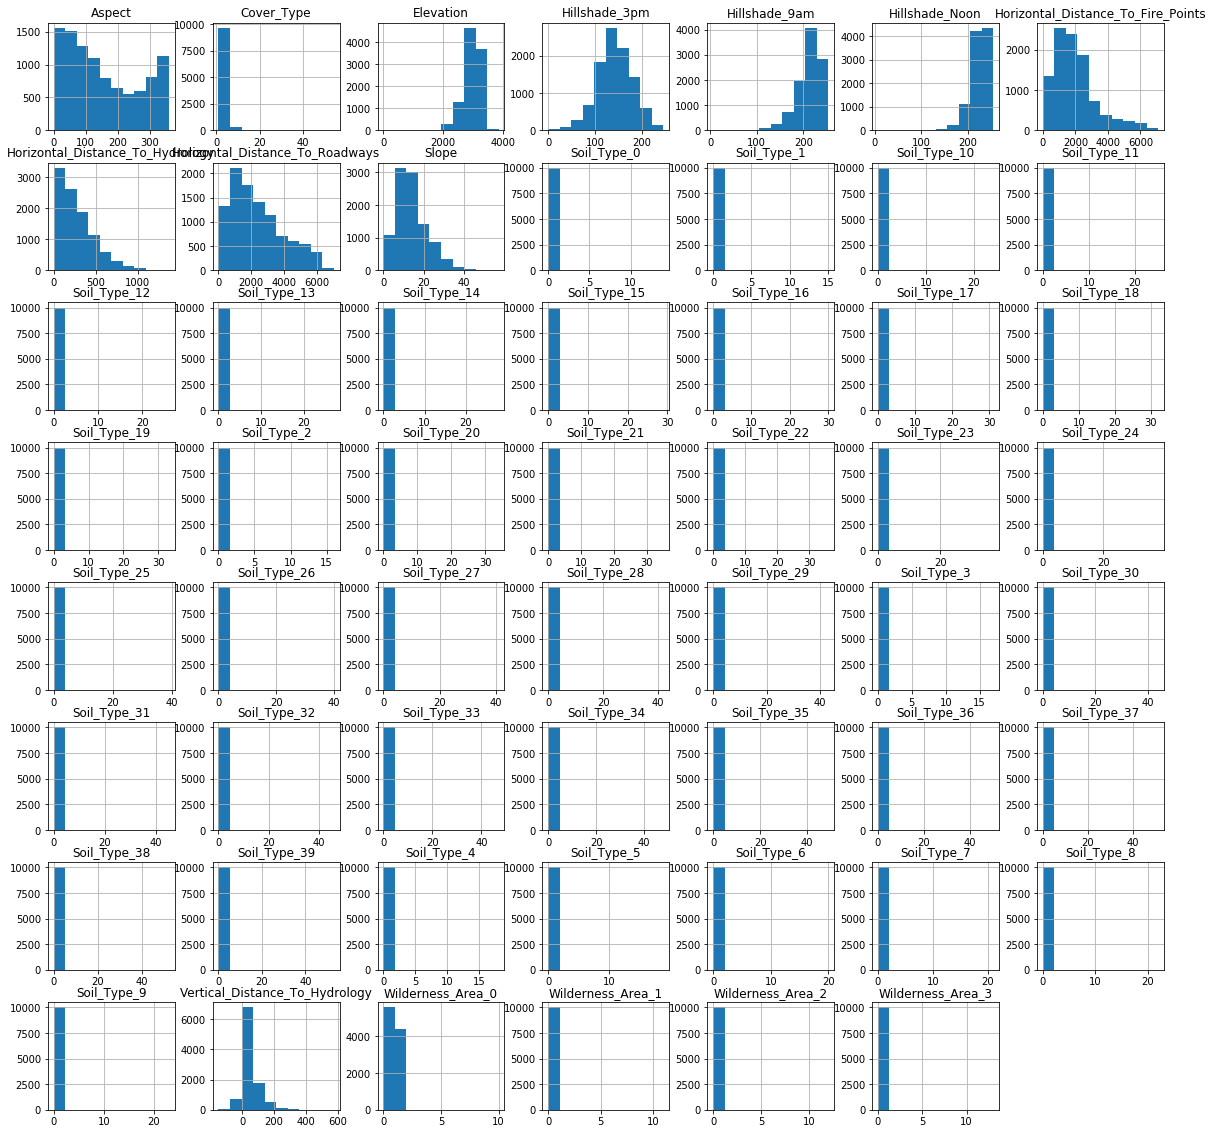

In [45]:
all_data.hist(figsize=(20, 20))
None

In [120]:
corr = all_data.corr()
mask = corr['Cover_Type'] > 0.38
corr = corr.loc[mask, mask]
data = all_data.loc[:, mask]
corr.style.background_gradient(cmap='coolwarm')

,Wilderness_Area_3,Soil_Type_9,Soil_Type_37,Cover_Type
Wilderness_Area_3,1.000000,0.625855,0.440075,0.446222
Soil_Type_9,0.625855,1.000000,0.663462,0.423592
Soil_Type_37,0.440075,0.663462,1.000000,0.385896
Cover_Type,0.446222,0.423592,0.385896,1.000000


In [129]:
data = all_data[all_data.columns[mask]]
data['Cover_Type']

0        54
1         2
2         1
3         2
4         1
         ..
9996      2
9997      2
9998      2
9999      2
10000     2
Name: Cover_Type, Length: 10001, dtype: int64

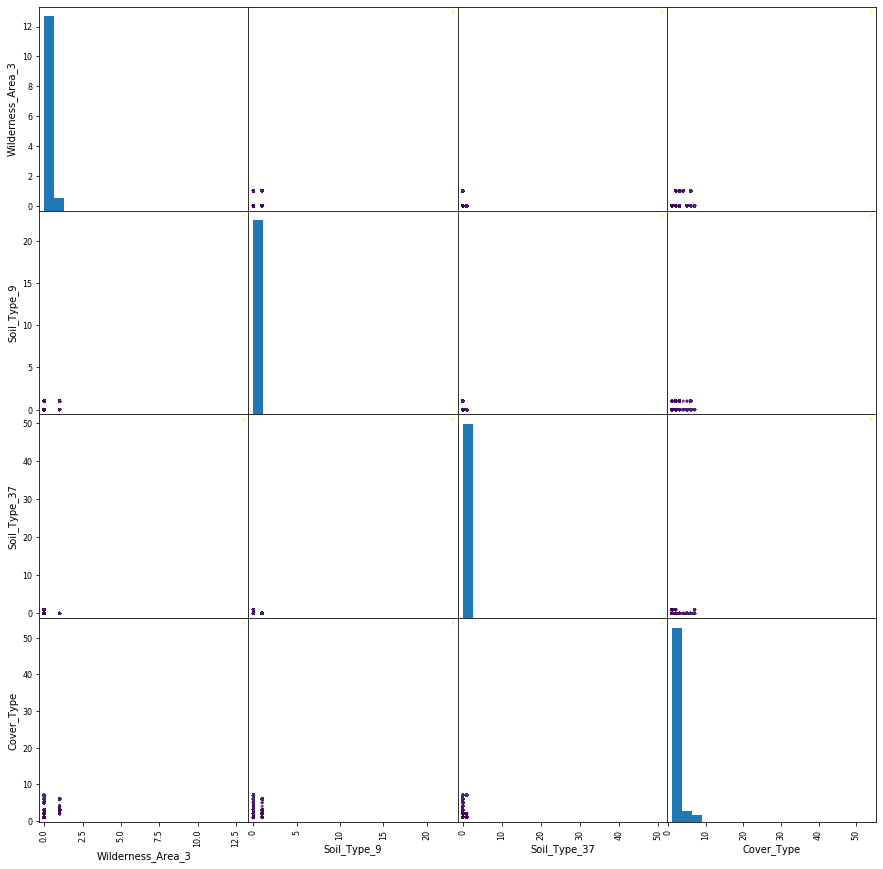

In [132]:
pd.plotting.scatter_matrix(data, c=data['Cover_Type'], figsize=(15, 15), hist_kwds={'bins': 20})
None

Выделим значения метки класса в переменную `labels`, признаковые описания --- в переменную `feature_matrix`. Так как данные числовые и не имеют пропусков, переведем их в `numpy`-формат с помощью метода `.values`.

In [5]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

### Пара слов о sklearn

**[sklearn](https://scikit-learn.org/stable/index.html)** -- удобная библиотека для знакомства с машинным обучением. В ней реализованны большинство стандартных алгоритмов для построения моделей и работ с выборками. У неё есть подробная документация на английском, с которой вам придётся поработать.

`sklearn` предпологает, что ваши выборки имеют вид пар $(X, y)$, где $X$ -- матрица признаков, $y$ -- вектор истинных значений целевой переменной, или просто $X$, если целевые переменные неизвестны.

Познакомимся со вспомогательной функцией 
[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
С её помощью можно разбить выборку на обучающую и тестовую части.

In [6]:
from sklearn.model_selection import train_test_split

Вернёмся к датасету. Сейчас будем работать со всеми 7 типами покрытия (данные уже находятся в переменных `feature_matrix` и `labels`, если Вы их не переопределили). Разделим выборку на обучающую и тестовую с помощью метода `train_test_split`.

In [8]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

In [12]:
train_feature_matrix.shape

(8000, 54)

Параметр `test_size` контролирует, какая часть выборки будет тестовой. Более подробно о нём можно прочитать в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Основные объекты `sklearn` -- так называемые `estimators`, что можно перевести как *оценщики*, но не стоит, так как по сути это *модели*. Они делятся на **классификаторы** и **регрессоры**.

В качестве примера модели можно привести классификаторы
[метод ближайших соседей](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) и 
[логистическую регрессию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Что такое логистическая регрессия и как она работает сейчас не важно.

У всех моделей в `sklearn` обязательно должно быть хотя бы 2 метода (подробнее о методах и классах в python будет в следующих занятиях) -- `fit` и `predict`.

Метод `fit(X, y)` отвечает за обучение модели и принимает на вход обучающую выборку в виде *матрицы признаков* $X$ и *вектора ответов* $y$.

У обученной после `fit` модели теперь можно вызывать метод `predict(X)`, который вернёт предсказания этой модели на всех объектах из матрицы $X$ в виде вектора.

Вызывать `fit` у одной и той же модели можно несколько раз, каждый раз она будет обучаться заново на переданном наборе данных.

Ещё у моделей есть *гиперпараметры*, которые обычно задаются при создании модели.

Рассмотрим всё это на примере логистической регрессии.

In [9]:
from sklearn.linear_model import LogisticRegression

In [16]:
# создание модели с указанием гиперпараметра C
clf = LogisticRegression(C=1)
# обучение модели
clf.fit(train_feature_matrix, train_labels)
# предсказание на тестовой выборке
# y_pred = clf.predict(test_feature_matrix)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Теперь хотелось бы измерить качество нашей модели. Для этого можно использовать метод `score(X, y)`, который посчитает какую-то функцию ошибки на выборке $X, y$, но какую конкретно уже зависит от модели. Также можно использовать одну из функций модуля `metrics`, например [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), которая, как понятно из названия, вычислит нам точность предсказаний.

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(test_labels, y_pred)

0.678

Наконец, последним, о чём хотелось бы упомянуть, будет перебор гиперпараметров по сетке. Так как у моделей есть много гиперпараметров, которые можно изменять, и от этих гиперпараметров существенно зависит качество модели, хотелось бы найти наилучшие в этом смысле параметры. Самый простой способ это сделать -- просто перебрать все возможные варианты в разумных пределах.

Сделать это можно с помощью класса [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), который осуществляет поиск (search) по сетке (grid) и вычисляет качество модели с помощью кросс-валидации (CV).

У логистической регрессии, например, можно поменять параметры `C` и `penalty`. Сделаем это. Учтите, что поиск может занять долгое время. Смысл параметров смотрите в документации.

In [18]:
from sklearn.model_selection import GridSearchCV

In [25]:
# заново создадим модель, указав солвер
clf = LogisticRegression(solver='saga')

# опишем сетку, по которой будем искать
param_grid = {
    'C': np.arange(1, 5), # также можно указать обычный массив, [1, 2, 3, 4]
    'penalty': ['l1', 'l2'],
}

# создадим объект GridSearchCV
search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')

# запустим поиск
search.fit(feature_matrix, labels)

# выведем наилучшие параметры
print(search.best_params_)

{'C': 1, 'penalty': 'l1'}


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [111]:
res = search.cv_results_
res = pd.DataFrame(res)
# res.filter(regex='(?!param.*)')
import re
re.search('(?!param)', 'penalty')

<re.Match object; span=(0, 0), match=''>

В данном случае, поиск перебирает все возможные пары значений C и penalty из заданных множеств.

In [20]:
accuracy_score(labels, search.best_estimator_.predict(feature_matrix))

0.6419

Заметьте, что мы передаём в GridSearchCV всю выборку, а не только её обучающую часть. Это можно делать, так как поиск всё равно использует кроссвалидацию. Однако порой от выборки всё-же отделяют *валидационную* часть, так как гиперпараметры в процессе поиска могли переобучиться под выборку.

В заданиях вам предстоит повторить это для метода ближайших соседей.

### Обучение модели

Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров:

* число соседей `n_neighbors`
* метрика расстояния между объектами `metric`
* веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос") `weights`


Обучите на датасете `KNeighborsClassifier` из `sklearn`.

In [138]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier()
clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)
accuracy_score(test_labels, y_pred)

0.7365

### Вопрос 1:
* Какое качество у вас получилось?

Подберём параметры нашей модели

* Переберите по сетке от `1` до `10` параметр числа соседей

* Также вы попробуйте использоввать различные метрики: `['manhattan', 'euclidean']`

* Попробуйте использовать различные стратегии вычисления весов: `[‘uniform’, ‘distance’]`

In [143]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': np.arange(10), 'metric':  ['manhattan', 'euclidean'], 'weights': ['uniform', 'distance']}

clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(feature_matrix, labels)
pd.DataFrame(clf_grid.cv_results_)
# Теперь обучение. Ваш код здесь

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.085065,0.027914,0.000000,0.000000,manhattan,0,uniform,"{'metric': 'manhattan', 'n_neighbors': 0, 'wei...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
1,0.044422,0.003011,0.000000,0.000000,manhattan,0,distance,"{'metric': 'manhattan', 'n_neighbors': 0, 'wei...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
2,0.049125,0.006355,0.252039,0.014995,manhattan,1,uniform,"{'metric': 'manhattan', 'n_neighbors': 1, 'wei...",0.7775,0.7940,0.7835,0.7785,0.7730,0.7813,0.007174,4
3,0.042823,0.010113,0.131091,0.023938,manhattan,1,distance,"{'metric': 'manhattan', 'n_neighbors': 1, 'wei...",0.7775,0.7940,0.7835,0.7785,0.7730,0.7813,0.007174,4
4,0.038620,0.001558,0.269527,0.003090,manhattan,2,uniform,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.7275,0.7465,0.7465,0.7255,0.7505,0.7393,0.010572,29
5,0.040487,0.005510,0.162822,0.007392,manhattan,2,distance,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.7785,0.7940,0.7830,0.7795,0.7740,0.7818,0.006742,2
6,0.042848,0.004476,0.308337,0.023692,manhattan,3,uniform,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.7595,0.7725,0.7545,0.7645,0.7665,0.7635,0.006132,18
7,0.038183,0.003913,0.185942,0.008531,manhattan,3,distance,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.7750,0.7870,0.7695,0.7835,0.7850,0.7800,0.006656,8
8,0.042796,0.006103,0.318653,0.017234,manhattan,4,uniform,"{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.7435,0.7590,0.7515,0.7375,0.7550,0.7493,0.007801,24
9,0.044808,0.006322,0.206664,0.007073,manhattan,4,distance,"{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.7800,0.8000,0.7810,0.7860,0.7880,0.7870,0.007155,1


Выведем лучшие параметры

In [144]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

In [145]:
type(clf_grid)

sklearn.model_selection._search.GridSearchCV

### Вопрос 2:
* Какую metric следует использовать?

### Вопрос 3:
* Сколько n_neighbors следует использовать?

### Вопрос 4:
* Какой тип weights следует использовать?

Используя найденное оптимальное число соседей, вычислите вероятности принадлежности к классам для тестовой выборки (`.predict_proba`).

In [149]:
optimal_clf = clf_grid.best_estimator_
optimal_clf.fit(train_feature_matrix, train_labels)
pred_prob = optimal_clf.predict_proba(test_feature_matrix)
pred_prob.shape

(2000, 7)

[1 2 3 4 5 6 7] [736 973 111  11  33  56  80]
[0.368, 0.4865, 0.0555, 0.0055, 0.0165, 0.028, 0.04]
[0.38140213 0.48906359 0.05292089 0.00581434 0.01521326 0.02623053
 0.02935526]


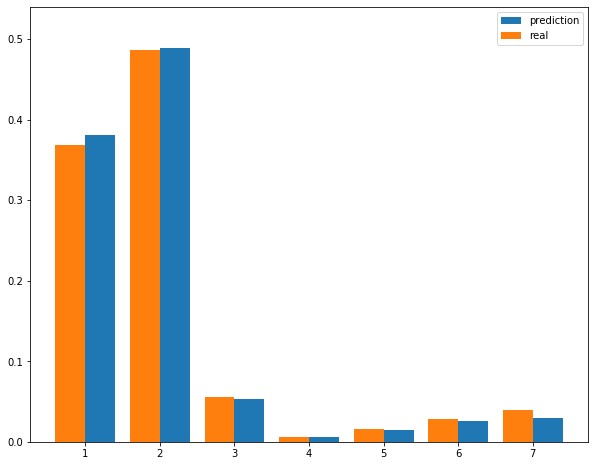

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
print(unique, freq)
freq = list(map(lambda x: x / len(test_labels),freq))
print(freq)
pred_freq = pred_prob.mean(axis=0)
print(pred_freq)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

### Вопрос 5:
* Какая прогнозируемая вероятность pred_freq класса под номером 3 (до 2 знаков после запятой)?